In [129]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'sans-serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [6]:
int32e = np.dtype(np.int32).newbyteorder('>')
uint8e = np.dtype(np.uint8).newbyteorder('>')

In [7]:
def load_images(filename):
    with gzip.open(filename, 'r') as fin:
        buf = fin.read(16)
        _, cnt, rows, cols = np.frombuffer(buf, dtype = int32e)
        buf = fin.read(cnt * rows * cols)
        arr = np.frombuffer(buf, dtype = uint8e).astype('float')
        arr = arr.reshape(cnt, rows, cols) / 255
    return arr
def load_labels(filename):
    with gzip.open(filename, 'r') as fin:
        buf = fin.read(8)
        _, cnt = np.frombuffer(buf, dtype = int32e)
        buf = fin.read(cnt)
        arr = np.frombuffer(buf, dtype = uint8e).astype(np.uint8)
    return arr

In [8]:
def show_image(img):
    img = np.asarray(img).squeeze()
    plt.imshow(img)
    plt.show()

In [9]:
def sample(a):
    return (a > np.random.rand(*a.shape)).astype('float')

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [10]:
class RBMClassifier:
    
    def __init__(self, visible_num, classes_num, hidden_num):
        self.visible_num = visible_num
        self.classes_num = classes_num
        self.hidden_num = hidden_num
        normal = lambda s: np.random.default_rng().normal(0, 0.1, s)
        self.W = normal((hidden_num, visible_num))
        self.b = normal((visible_num, 1))
        self.c = normal((hidden_num, 1))
        self.d = normal((classes_num, 1))
        self.U = normal((hidden_num, classes_num))
        self.log = {
            'loss' : []
        }
    
    def train(self, epochs, data, labels, minibatch_size, learning_rate, cycle_length):
        M = data.shape[0]
        cycle_length *= M / minibatch_size
        it = 0
        for i in range(epochs):
            permutation = np.random.permutation(M)
            loss = 0;
            for b in range(0, M, minibatch_size):
                minibatch_data = data[permutation[b : b + minibatch_size]]
                minibatch_labels = labels[permutation[b : b + minibatch_size]]
                x0 = sample(minibatch_data).T
                y0 = np.identity(self.classes_num, dtype = 'float')[minibatch_labels].T

                h0P = sigmoid(self.c + self.W @ x0 + self.U @ y0)
                wakeW = h0P @ x0.T
                wakeU = h0P @ y0.T

                h0 = sample(h0P)
                x1 = sample(sigmoid(self.b + self.W.T @ h0))
                y1 = sample(sigmoid(self.d + self.U.T @ h0))
                h1P = sigmoid(self.c + self.W @ x1 + self.U @ y1)
                dreamW = h1P @ x1.T
                dreamU = h1P @ y1.T
                
                alpha = learning_rate[1] + .5 * sum(learning_rate) * (1 + np.cos(np.pi * it / cycle_length))
                self.W += alpha * (wakeW - dreamW) / minibatch_size
                s = lambda v: np.sum(v, axis = 1, keepdims = True)
                self.b += alpha * (s(x0) - s(x1)) / minibatch_size
                self.c += alpha * (s(h0P) - s(h1P)) / minibatch_size
                self.d += alpha * (s(y0) - s(y1)) / minibatch_size
                self.U += alpha * (wakeU - dreamU) / minibatch_size
                it += 1
                if it >= cycle_length:
                    it = 0
                
                loss += np.sum((x0 - x1) ** 2) + np.sum((y0 - y1) ** 2)
            self.log['loss'].append(loss / M)
            print('.', end = '')
        print()
    
    def predict(self, data):
        if len(data.shape) == 1:
            data = data[None, :]
        x = data.T
        t = (self.c + self.U)[:, :, None] + (self.W @ x)[:, None, :]
        P = np.exp(self.d) * np.product(1 + np.exp(t), axis = 0)
        return np.argmax(P, axis = 0)
    
    def generate(self, digit, init, iterations = 10):
        x = sample(init).T
        x.shape = (x.size, 1)
        y = np.zeros((self.classes_num, 1), dtype = 'float')
        y[digit, 0] = 1
        for it in range(iterations):
            h = sample(sigmoid(self.c + self.W @ x + self.U @ y))
            xP = sigmoid(self.b + self.W.T @ h)
            x = sample(xP)
        return xP

In [11]:
train_data = load_images('train-images-idx3-ubyte.gz')
train_data = train_data.reshape(train_data.shape[0], -1)
train_labels = load_labels('train-labels-idx1-ubyte.gz')

In [13]:
rbm = RBMClassifier(train_data.shape[1], 10, 100)

In [712]:
rbm.train(300, train_data, train_labels, 1000, [5e-1,5e-3], 50)

............................................................................................................................................................................................................................................................................................................


[8049166.418000001, 5582769.729000001, 5000494.930000002, 4683543.198000001, 4451203.347, 4284547.483, 4155928.6760000004, 4054317.139000001, 3963022.0000000014, 3884557.287999999, 3808526.4699999997, 3736351.856, 3676607.479, 3619464.9209999996, 3569511.3719999995, 3523415.0249999985, 3483277.3049999983, 3445403.989000001, 3411279.5510000004, 3379654.0769999987, 3348600.9589999984, 3325143.5930000003, 3307013.992, 3279871.987, 3261855.661000001, 3245707.460000001, 3226135.4230000004, 3213383.1969999997, 3196482.8899999987, 3182590.856000002, 3174306.544, 3162744.5319999997, 3150265.226000001, 3143774.0469999993, 3133224.8760000006, 3123763.8480000007, 3119002.6190000004, 3109800.6540000006, 3101085.5349999997, 3097116.317, 3091096.241, 3087832.2450000015, 3082515.9030000004, 3075354.0229999996, 3073644.9700000007, 3069843.7880000006, 3063194.748, 3060917.6109999996, 3055926.6180000002, 3054570.384, 3052392.421, 3044553.5650000004, 3042966.414, 3037573.1399999997, 3038699.2480000006, 3

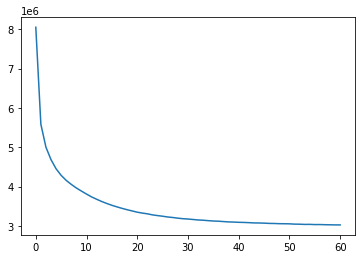

In [91]:
plt.plot(rbm.log['loss'])
print(rbm.log['loss'])

In [504]:
rbm.predict(train_data[10:20])

[[1.31124783e+85 7.75301753e+39 3.18822331e+69 2.56540076e+80
  5.69093737e+67 5.82097581e+75 4.74348136e+45 2.73392210e+70
  5.83398064e+48 7.96236868e+64]
 [7.29987469e+84 6.13991581e+41 3.27107063e+69 2.31201612e+78
  2.51364956e+78 4.57279700e+74 1.20993888e+42 2.86067571e+70
  1.54762946e+49 4.19726114e+65]
 [1.87444976e+87 2.32852479e+41 6.01932053e+70 3.79049698e+78
  2.04849215e+71 9.16331360e+72 1.39589141e+47 1.72478209e+71
  2.29553540e+49 1.13336319e+64]
 [6.44228866e+89 4.77112347e+39 9.74589029e+73 3.85090346e+77
  9.49673043e+70 4.21748664e+73 1.32976153e+44 2.78347865e+71
  1.06283060e+50 2.11008099e+65]
 [7.60335212e+84 5.54066904e+41 5.10212983e+68 1.91650975e+80
  1.13795894e+72 8.50174791e+75 1.19768962e+45 3.99350559e+71
  3.78885206e+49 1.93613753e+67]
 [3.31073685e+87 1.40948623e+43 2.65392463e+71 6.21589958e+78
  7.00807441e+71 1.81380567e+75 4.06077961e+42 1.92684496e+71
  1.00323622e+51 1.77454587e+65]
 [1.86786968e+86 5.10550007e+40 1.04198404e+70 2.46813174e

array([3, 5, 3, 6, 1, 7, 2, 8, 6, 9])

In [15]:
for x in train_data[7]:
    print(x)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.14901960784313725
0.16862745098039217
0.4117647058823529
1.0
0.9921568627450981
0.9921568627450981
0.9921568627450981
0.9921568627450981
0.9921568627450981
0.6823529411764706
0.023529411764705882
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.16862745098039217
0.5450980392156862
0.8784313725490196
0.8862745098039215
0.9882352941176471
0.9921568627450981
0.9882352941176471
0.98

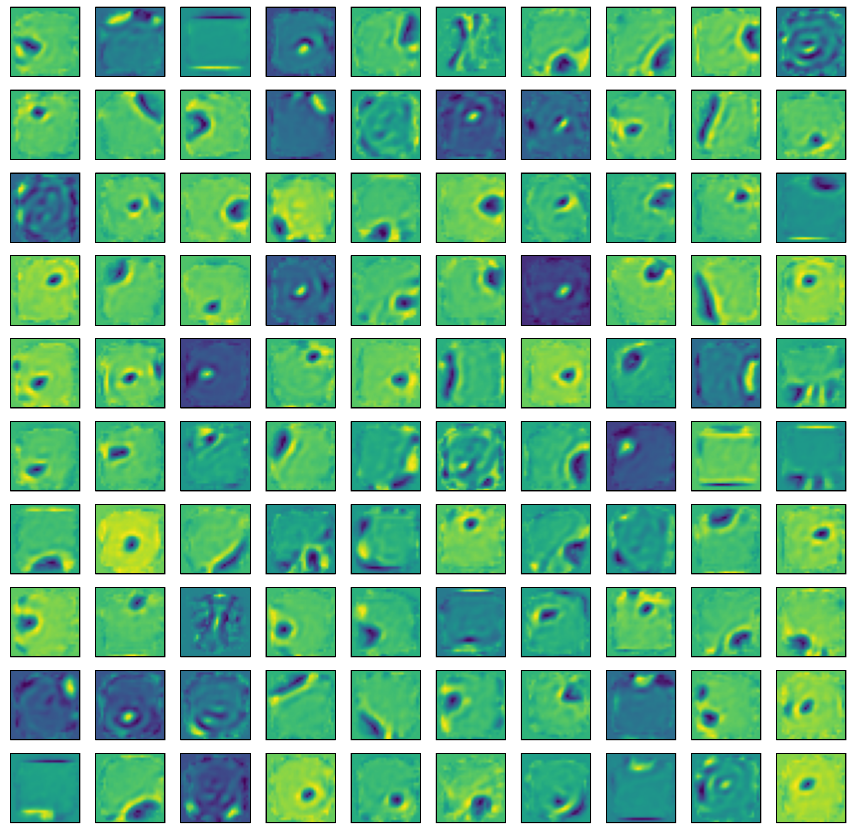

In [148]:
fig, axes = plt.subplots(10, 10)
fig.set_size_inches(15, 15)
for i in range(100):
    a = axes[i // 10][i % 10]
    a.set_xticks([])
    a.set_yticks([])
    a.patch.set_edgecolor('black')
    a.patch.set_linewidth(1)
    a.imshow(rbm.W[i].reshape(28, 28).squeeze())
plt.savefig('neuron_activations.png')

In [14]:
test_data = load_images('t10k-images-idx3-ubyte.gz')
test_data = test_data.reshape(test_data.shape[0], -1)
test_labels = load_labels('t10k-labels-idx1-ubyte.gz')

In [155]:
np.sum(rbm.predict(train_data) == train_labels) / train_labels.size * 100

92.80166666666668

In [2]:
import pickle

In [9]:
pickle.dump(rbm, open('checkpoint2', 'wb'))

NameError: name 'pickle' is not defined

In [12]:
rbm = pickle.load(open('100neurons-checkpoints/checkpoint9999', 'rb'))

<ipython-input-135-0e8cfcaa6d54>:12: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


0.8774915670039866 0.0015332720024532351 0.0019932536031892056 0.0016865992026985587 0.0016865992026985587 0.005059797608095676 0.004753143207605029 0.0012266176019625882 0.01134621281815394 0.0013799448022079118
0.00015332720024532353 1.0 0.011652867218644588 0.004139834406623735 0.0022999080036798527 0.0013799448022079118 0.0026065624041705 0.003833180006133088 0.0068997240110395585 0.0007666360012266176
0.003833180006133088 0.008892977614228765 0.828886844526219 0.013186139221097824 0.014259429622815088 0.0030665440049064702 0.011806194418889911 0.011192885617908616 0.01349279362158847 0.004906470407850353
0.006593069610548912 0.005979760809567618 0.021005826433609324 0.8394664213431463 0.0006133088009812941 0.025145660840233057 0.003526525605642441 0.008739650413983441 0.021619135234590615 0.007359705611775529
0.0009199632014719411 0.0027598896044158236 0.003526525605642441 0.00045998160073597056 0.828886844526219 0.004139834406623735 0.0033731984053971173 0.003986507206378411 0.00

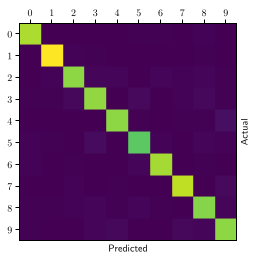

In [135]:
confusion_matrix = np.zeros((10, 10), dtype = float)
np.add.at(confusion_matrix, (train_labels, rbm.predict(train_data)), 1)
fig, ax = plt.subplots()
confusion_matrix /= np.amax(confusion_matrix)
ax.matshow(confusion_matrix, cmap = 'viridis')
plt.xticks(range(10))
plt.yticks(range(10))
plt.tick_params(bottom = False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.yaxis.set_label_position('right')
plt.show()
for r in confusion_matrix:
    print(*r)

3


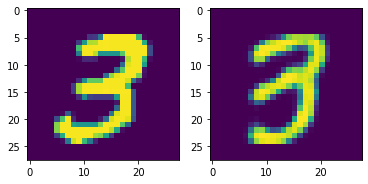

In [31]:
i = 7
fig, axes = plt.subplots(1,2)
axes[0].imshow(train_data[i].reshape((28, 28)))
axes[1].imshow(rbm.generate(train_labels[i], train_data[i], iterations = 20).reshape((28, 28)))
print(train_labels[i])

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '432x288', '-pix_fmt', 'rgba', '-r', '5.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'test.mp4']' returned non-zero exit status 255.

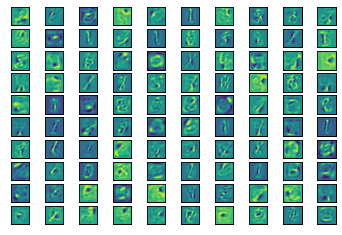

In [15]:
from matplotlib.animation import FuncAnimation
fig, axes = plt.subplots(10, 10)
def anim_init():
    fig.set_size_inches(15, 15)
    for i in range(100):
        a = axes[i // 10][i % 10]
        a.set_xticks([])
        a.set_yticks([])
        a.patch.set_edgecolor('black')
        a.patch.set_linewidth(1)
def anim_update(frame):
    W = pickle.load(open(f'run1-checkpoints/checkpoint{frame:04}', 'rb')).W
    for i in range(100):
        a = axes[i // 10][i % 10]
        a.imshow(W[i].reshape(28, 28).squeeze(), animated = True)
anim = FuncAnimation(fig, anim_update, frames = 60, init_func = anim_init, blit = False)
anim.save('test.mp4')
#plt.show()

In [151]:
from PIL import Image, ImageDraw
import os.path

In [149]:
cmap = plt.cm.get_cmap('viridis')
def image_activation(a):
    u, v = a.min(), a.max()
    pixels = (a - u) / (v - u)
    pixels = cmap(pixels)
    pixels = (pixels * 255).astype('uint8')[:, :, 0 : 3]
    return Image.fromarray(pixels)

def image_full(rbm0, rbm1, t):
    grid = (10, 10)
    activation_size = 28 * 4
    colsep, rowsep = 20, 20
    border = 2
    hmargin, vmargin = 40, 40
    imgw = 2 * hmargin + grid[0] * (activation_size + 2 * border) + (grid[0] - 1) * colsep
    imgh = 2 * vmargin + grid[1] * (activation_size + 2 * border) + (grid[1] - 1) * rowsep
    img = Image.new('RGB', (imgw, imgh), 'white')
    draw = ImageDraw.Draw(img)
    W = (1 - t) * rbm0.W + t * rbm1.W
    for i in range(grid[0]):
        for j in range(grid[1]):
            x = hmargin + i * (activation_size + 2 * border) + i * colsep
            y = vmargin + j * (activation_size + 2 * border) + j * rowsep
            act = image_activation(W[grid[0] * j + i].reshape(28, 28))
            act = act.resize((activation_size, activation_size), 0)
            draw.rectangle([x, y, x + activation_size + 2 * border - 1, y + activation_size + 2 * border - 1], 'black')
            img.paste(act, (x + border, y + border))
    return img

def make_video(filenames, output, interval, frames):
    load_checkpoint = lambda i: pickle.load(open(filenames.format(i), 'rb'))
    b, e = interval
    loss = np.array(load_checkpoint(e).log['loss'])
    delta = np.zeros(loss.shape)
    delta[1 :] = np.log(np.abs(loss[1 :] - loss[: -1]))
    delta = delta.cumsum()
    delta *= (frames - 1) / delta[-1]
    i = 0
    rbm1 = load_checkpoint(0)
    for f in range(frames):
        j = np.searchsorted(delta, f) or 1
        if j > i:
            rbm0 = rbm1
            rbm1 = load_checkpoint(j)
            if j > i + 1:
                rbm0 = load_checkpoint(j - 1)
            i = j
        t = (f - delta[i - 1]) / (delta[i] - delta[i - 1])
        img = image_full(rbm0, rbm1, t)
        img.save(os.path.join(output, f'frame{f:04}.png'))

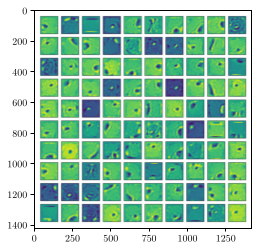

In [153]:
#make_video('run1-checkpoints/checkpoint{:04}', 'video', [0, 60], 300)
img = image_full(rbm,rbm,0)
plt.imshow(img)
img.save('img.png')
#plt.imshow(rbm.W[0].reshape(28, 28))

In [154]:
print(rbm.W[0])

[-2.98441743e-01 -2.83396706e-01 -2.68159233e-01 -2.66876279e-01
 -2.74439862e-01 -2.90759922e-01 -2.95710807e-01 -3.02721355e-01
 -3.02006700e-01 -2.92350160e-01 -3.09837059e-01 -2.80311047e-01
 -3.08671322e-01 -4.01628554e-01 -3.10132441e-01 -3.25279814e-01
 -2.82427196e-01 -2.84709259e-01 -2.99957364e-01 -2.86315603e-01
 -3.04076271e-01 -2.87651031e-01 -2.90732204e-01 -2.78283509e-01
 -2.67022143e-01 -2.84063352e-01 -2.78791958e-01 -2.97913662e-01
 -2.95147286e-01 -2.92833862e-01 -2.81836220e-01 -2.95720246e-01
 -2.81628387e-01 -2.83933106e-01 -3.75847054e-01 -3.88425129e-01
 -3.36604799e-01 -3.82839598e-01 -4.97048152e-01 -5.07796879e-01
 -3.96501895e-01 -3.71457185e-01 -3.62280837e-01 -3.93392852e-01
 -4.79699331e-01 -4.92604870e-01 -4.26058541e-01 -4.21189309e-01
 -4.14099136e-01 -3.93837533e-01 -3.83863058e-01 -3.33447401e-01
 -2.86538840e-01 -3.02980330e-01 -2.87686364e-01 -2.92529481e-01
 -2.72116322e-01 -2.83018188e-01 -2.81206650e-01 -3.00693121e-01
 -3.49780353e-01 -3.57219

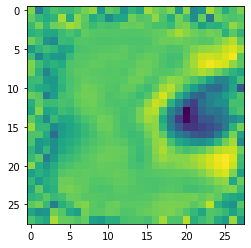

In [87]:
plt.imshow((rbm.W[0].reshape(28,28) + rbm.W[0].min()) / (rbm.W[0].max() - rbm.W[0].min()),cmap='viridis')

In [46]:
a=np.zeros((4,4))
np.add.at(a,([1,1,1,0],[0,1,0,0]), 1)
a

array([[1., 0., 0., 0.],
       [2., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])